In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("../data/processed/telco_churn_processed.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0-12
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,25-48
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0-12
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,25-48
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0-12


In [2]:
df["Churn_Flag"] = df["Churn"].apply(lambda x: 1 if x == "Yes" else 0)

X = df.drop(["Churn", "Churn_Flag"], axis=1)
y = df["Churn_Flag"]

X.head(), y.head()

(   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
 0  7590-VHVEG  Female              0     Yes         No       1           No   
 1  5575-GNVDE    Male              0      No         No      34          Yes   
 2  3668-QPYBK    Male              0      No         No       2          Yes   
 3  7795-CFOCW    Male              0      No         No      45           No   
 4  9237-HQITU  Female              0      No         No       2          Yes   
 
       MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
 0  No phone service             DSL             No  ...               No   
 1                No             DSL            Yes  ...              Yes   
 2                No             DSL            Yes  ...               No   
 3  No phone service             DSL            Yes  ...              Yes   
 4                No     Fiber optic             No  ...               No   
 
   TechSupport StreamingTV StreamingMovies      

In [3]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

numeric_features, categorical_features[:10] 

(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'],
 ['customerID',
  'gender',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection'])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((5625, 21), (1407, 21))

In [5]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

In [6]:
logreg_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LogisticRegression(max_iter=1000))
    ]
)

logreg_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['customerID', 'gender',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'tenure_group'])])),
                ('model', LogisticRegression(max_iter=1000))])

In [7]:
y_pred = logreg_clf.predict(X_test)
y_prob = logreg_clf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7917555081734187
Precision: 0.6302250803858521
Recall: 0.5240641711229946
F1 Score: 0.5722627737226277
ROC-AUC: 0.8345830895941938

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.63      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.73      0.71      0.72      1407
weighted avg       0.78      0.79      0.79      1407



In [8]:
import joblib

joblib.dump(logreg_clf, "../models/churn_logreg.pkl")

['../models/churn_logreg.pkl']

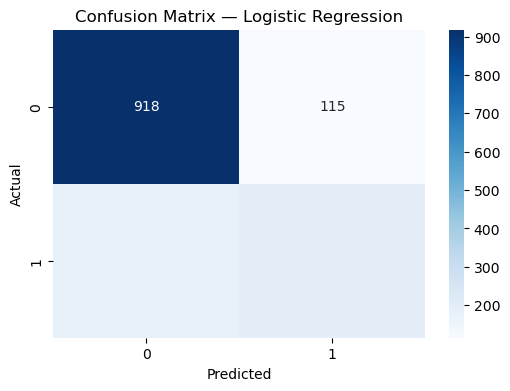

In [9]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Logistic Regression")
plt.show()

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            min_samples_split=2,
            random_state=42
        ))
    ]
)

rf_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['customerID', 'gender',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'tenure_group'])])),
                ('model',
                 RandomForestClassifier(n_estimators=300, random_state=42))])

In [11]:
y_pred_rf = rf_clf.predict(X_test)
y_prob_rf = rf_clf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

Accuracy: 0.7860696517412935
Precision: 0.627177700348432
Recall: 0.48128342245989303
F1 Score: 0.5446293494704992
ROC-AUC: 0.8259366053910784

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.63      0.48      0.54       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.79      0.78      1407



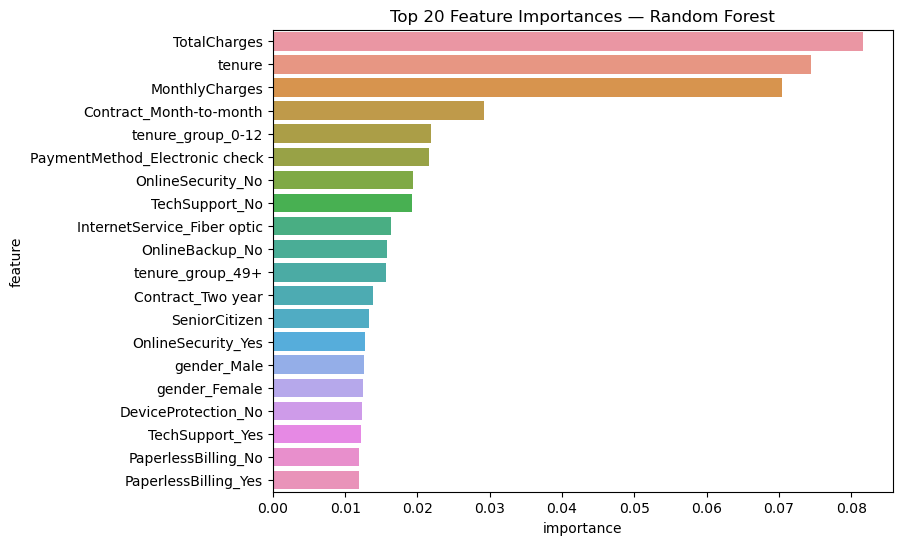

In [12]:
# Extract feature names after OneHotEncoding
ohe = rf_clf.named_steps["preprocessor"].named_transformers_["cat"]
encoded_cat_cols = ohe.get_feature_names_out(categorical_features)

all_feature_names = np.concatenate([numeric_features, encoded_cat_cols])

# Get importance
importances = rf_clf.named_steps["model"].feature_importances_

feat_imp = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(data=feat_imp, x="importance", y="feature")
plt.title("Top 20 Feature Importances — Random Forest")
plt.show()

In [13]:
joblib.dump(rf_clf, "../models/churn_random_forest.pkl")

['../models/churn_random_forest.pkl']